### DQN - Cartpole

Dans cette tâche, les récompenses sont de +1 pour chaque pas de temps et l'environnement se termine si le poteau tombe trop loin ou si le chariot se déplace plus de 2.4 unités du centre. Cela signifie que les scénarios les plus performants s'exécuteront plus longtemps.

In [3]:
%matplotlib inline

In [2]:
%%bash
pip3 install gymnasium[classic_control]
pip install gymnasium[box2d]
pip install pygame 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 39.7 MB/s eta 0:00:00
  Attempting uninstall: pygame
    Found existing installation: pygame 2.3.0
    Uninstalling pygame-2.3.0:
      Successfully uninstalled pygame-2.3.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 52.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 38.4 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for box2d-py
Failed to build box2d-py
  Running setup.py install for box2d-py: started
  Running setup.py install for box2d-py: finished with status 'done'
Looking in indexes: https://pypi.org/simple, 

  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for box2d-py
  DEPRECATION: box2d-py was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. pip 23.1 will enforce this behaviour change. A possible replacement is to fix the wheel build issue reported above. Discussion can be found at https://github.com/pypa/pip/issues/8368


In [4]:
import os
os.environ['SDL_VIDEODRIVER']='dummy'
import pygame
pygame.display.set_mode((640,480))

pygame 2.1.3 (SDL 2.0.22, Python 3.10.11)
Hello from the pygame community. https://www.pygame.org/contribute.html


<Surface(640x480x32 SW)>

In [5]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
print(gym.__version__)
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = gym.make("CartPole-v1", render_mode="rgb_array")

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

0.28.1


## Replay Memory

Nous utiliserons de l'experience replay  pour entrainer notre. Il enregistre les transitions que l'agent observe pour pouvoir les réutiliser plus tard. En échantillonant aléatoirement les transitions, on peut créer batch de transitions décorrélées entre elles. Cette technique est utilisée pour augmenter la stabilité de la procédure d'entrainement 

In [ ]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

## DQN algorithm

Nous devons minimiser :

\begin{align}\delta = Q(s, a) - (r + \gamma \max_a' Q(s', a))\end{align}

On utilise la Huber Loss pour minimiser $\delta $ :   
* Quand l'erreur est petite, elle est similaire a la RMSE
* Quand l'erreur est grande, elle est similaire a la Mean Absolute Error

Ce choix de Loss function permet de stabiliser l'algorithme quand $Q$ devient très bruité : 


\begin{align}\mathcal{L} = \frac{1}{|B|}\sum_{(s, a, s', r) \ \in \ B} \mathcal{L}(\delta)\end{align}

\begin{align} \quad \mathcal{L}(\delta) = \begin{cases}
     \frac{1}{2}{\delta^2}  & \text{si} |\delta| \le 1, \\
     |\delta| - \frac{1}{2} & \text{sinon}
   \end{cases}\end{align}


In [ ]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

## Hyperparamètres




In [ ]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

n_actions = env.action_space.n
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0


def select_action(state,evaluation=False):
    global steps_done 
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if random.random() > eps_threshold or (evaluation):
       # Action choisie selon la politique optimale
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else: 
        # Action aléatoire
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.plot(durations_t.numpy())
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

### La boucle d'entrainement : 

``optimize_model`` réalise une étape d'optimisation. 

* On échantillone un batch, on calcule $Q(s_t, a_t)$ et
$V(s_{t+1}) = \max_a Q(s_{t+1}, a)$ puis on les combine dans la loss function.

* On utilise également un réseau cible pour calculer $V(s_{t+1})$ 




In [ ]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # V(s_{t+1}) for all next states
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize
    optimizer.zero_grad()
    loss.backward()

    # Gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

**Training loop**

L'entrainement du DQN peut être instable, même avec l'utilisation d'un grand replay memory buffer. Si l'entrainement n'a pas convergé, exécuter la cellule suivante une seconde fois.

Complete


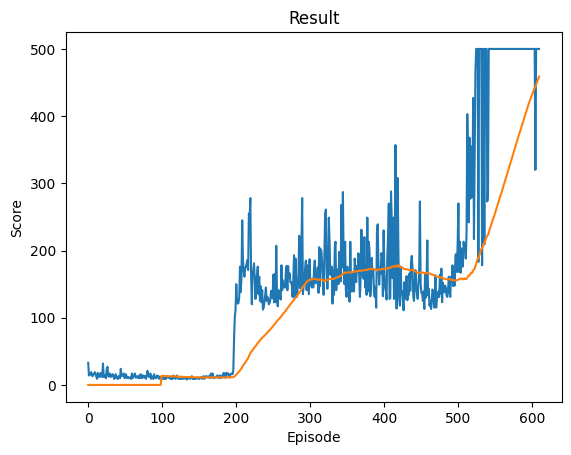

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
if torch.cuda.is_available():
    num_episodes = 600 
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        memory.push(state, action, next_state, reward)
        state = next_state
        optimize_model()

        # θ′ ← τ θ + (1 −τ)θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

plot_durations(show_result=True)
plt.ioff()
plt.show()

# Resultats 

Enregistre les frames d'un épisode pour l'agent entrainé

In [ ]:
import matplotlib.pyplot as plt 
import time 
from google.colab.patches import cv2_imshow
from IPython.display import clear_output
from time import sleep
import os.path
import shutil

shutil.rmtree("/content/videos")
os.mkdir('/content/videos/')
os.mkdir('/content/videos/trained_agent')

state, info = env.reset()
state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
frame_id = 0
for frame_id in range(1000):
    
    env_screen = env.render()    
    plt.imsave(f"/content/videos/trained_agent/{frame_id}.png",env_screen)
    frame_id +=1
    
    # Select the action following the policy (epsilon ignored)
    action = select_action(state,evaluation = True)
    observation, reward, terminated, truncated, _ = env.step(action.item())
    reward = torch.tensor([reward], device=device)
    done = terminated or truncated
    if terminated:
        next_state = None
        break
    else:
        next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

    # Move to the next state
    state = next_state


# Close the env
env.close()

Vidéo de l'agent entrainé

In [ ]:
import os
import cv2
from PIL import Image
import numpy as np

fps = 30
input_path = '/content/videos/trained_agent'
output_file = 'trained_agent.mp4'

def get_file_id(file_path):
    return int(os.path.splitext(os.path.basename(file_path))[0].split('_')[-1])
    
file_list = [os.path.join(input_path, f) for f in os.listdir(input_path) if f.endswith('.png')]
file_list = sorted(file_list, key=get_file_id)

# Get the size of the first PNG file
with Image.open(file_list[0]) as img:
    width, height = img.size

# Create a VideoWriter object to write the video
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_writer = cv2.VideoWriter(output_file, fourcc, fps, (width, height))

# Loop through each PNG file and write it to the video
for file_path in file_list:
    with Image.open(file_path) as img:
        frame = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
        video_writer.write(frame)

# Release the VideoWriter object
video_writer.release()
